In [1]:
import numpy as np
import os, sys
import h5py
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append('/Users/ajc/Core/SimDataInputs/ats-repo/ats-Aug6/tools/utils/')
sys.path.append('/Users/ajc/Core/PostProcessData/PyScript')

import readdata as rd
import parse_ats, transect_data
import datetime as DT
import matplotlib.dates as mdates

In [2]:
time_origin = DT.datetime(2010,1,1,0,0,0)

In [3]:
# Read Snow
def ObservedSnow(location='Center'):
    SnowData = dict()
    infile = '/Users/ajc/Core/SimDataInputs/observed_data_barrow/Vladimir-Data/SnowDepth/'
    infile_observed1 = infile + 'C_Snow_%s_2012-2013.csv'%location
    infile_observed2 = infile + 'C_Snow_%s_2013-2014.csv'%location
    datasnow1 = pd.read_csv(infile_observed1,skiprows=3)
    datasnow2 = pd.read_csv(infile_observed2,skiprows=3)

    dat1 = np.array([ x for x in datasnow1['1 Hour Moving Average']])
    dat2 = np.array([ x for x in datasnow2['1 Hour Moving Average']])
    
    SnowData1 = np.array([x/1. for i,x in enumerate(dat1)])
    SnowData2 = np.array([x/1. for i,x in enumerate(dat2)])
    
    time1 = [pd.to_datetime(datasnow1['TZ=UTC+0'])]
    time = np.array([(t - time_origin).dt.total_seconds()/86400 for t in time1])
    TimeSnow1 = np.array([t/365.25 for t in time[0]])
    
    
    time1 = [pd.to_datetime(datasnow2['TZ=UTC+0'])]
    time = np.array([(t - time_origin).dt.total_seconds()/86400 for t in time1])
    TimeSnow2 = np.array([t/365.25 for t in time[0]])
    
   
    mask = np.ones(len(SnowData1), dtype=bool)
    for i,d in enumerate(SnowData1):
        if d > 6000 or d < 0:
            mask[i] = False
    SnowData1 = SnowData1[mask]
    TimeSnow1 = TimeSnow1[mask]
    SnowData1 = SnowData1 / 100.
    L1 = len(SnowData1) - len(SnowData1)%24
    
    SnowData1 = np.reshape(SnowData1[:L1], (-1,24)).mean(axis=1)
    TimeSnow1 = np.reshape(TimeSnow1[:L1], (-1,24)).mean(axis=1)
    
    mask = np.ones(len(SnowData2), dtype=bool)
    for i,d in enumerate(SnowData2):
        if d > 6000 or d < 0:
            mask[i] = False
    SnowData2 = SnowData2[mask]
    TimeSnow2 = TimeSnow2[mask]

    SnowData2 = SnowData2 / 100.
    
    L2 = len(SnowData2) - len(SnowData2)%24
    
    SnowData2 = np.reshape(SnowData2[:L2], (-1,24)).mean(axis=1)
    TimeSnow2 = np.reshape(TimeSnow2[:L2], (-1,24)).mean(axis=1)
    SnowData['snow_time_%s'%location] = np.concatenate((TimeSnow1, TimeSnow2))
    SnowData['snow_depth_%s'%location] = np.concatenate((SnowData1,SnowData2))

    return SnowData

In [4]:
DataObservedSnow = dict()

DataObservedSnow = ObservedSnow('Center')
d2 = ObservedSnow('Rim')
d3 = ObservedSnow('Trough')
DataObservedSnow.update(d2)
DataObservedSnow.update(d3)
print (DataObservedSnow.keys())

dict_keys(['snow_time_Center', 'snow_depth_Center', 'snow_time_Rim', 'snow_depth_Rim', 'snow_time_Trough', 'snow_depth_Trough'])


In [5]:
import re
def sorted_nicely( l ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

def get_time_format(dat):
    Dat = []
    year = int(dat[0])
    year_start = DT.date(year,1,1)
    dateFormatted = year_start.strftime("%y")
    for i in dat:
        f = float(i)
        delta = year_start + DT.timedelta(days = int((i-year)*365) )
        Dat.append(delta)
    print (len(dat), len(Dat))
    return Dat

In [6]:
simulation = ['SiteC_3D_3R1C', 'SiteC_3D_3R1C'] # 1C limiter on snow density (basecase)
#simulation = ['SiteC_3D_3R1C', 'SiteC_3D_3R1F'] # Sensitivty tests 1B no limiter on snow density, 1C limiter on snow density (basecase)
#simulation = ['SiteC_3D_3R1E', 'SiteC_3D_3R1E'] # 1E EVAPORATION basecase

path = "/Users/ajc/Core/Projects/ATS-Data/OR-CONDO/simulations/barrow_icewedges/NGEE/SiteC_3D_June10/"

dir_files = os.listdir(path + simulation[0])
Vars = ['snow_depth-center', 'snow_depth-rightrim', 'snow_depth-righttrough','ponded_depth-center', 'ponded_depth-rightrim', 'ponded_depth-righttrough']
#Vars = ['snow_density-center', 'snow_density-rightrim', 'snow_density-righttrough']
#Vars = ['surface-evaporation-center', 'surface-evaporation-rightrim', 'surface-evaporation-righttrough']
SimName = ['S1', 'S2']
Files = dict()
for var in Vars:
    Files_Temp = [f for f in dir_files if f.startswith(var)]
    Files[var] = sorted_nicely(Files_Temp)


In [7]:
DataSimAll= dict()

temp_C = []
for i,sim in enumerate(simulation):
    Sname = SimName[i] + '-'
    for var in Vars:
        for files in Files[var]:
            dat = rd.ReadSingleFile(os.path.join(path+sim,files))
            DataSimAll[Sname + files[:-4]] = np.array(dat['data'])
            time = [t/86400. for t in dat['time']]
            assert len(dat['data']) == len(dat['time'])

DataSim1 = dict()
DataSim2 = dict()
DataSim2['Time'] = [2010 + t/365. for t in time]

#print (len(DataSim2['Time']))
for key in list(DataSimAll):#.keys():
    if SimName[0] in key:
        DataSim1[key[3:]] = DataSimAll[key]
    if SimName[1] in key:
        DataSim2[key[3:]] = DataSimAll[key]
#print (list(DataSim1))

In [8]:
for key in list(DataSim1):#.keys():
    K = key
    #print (K, len(list(DataSim1)))
    if 'right' in key:
        K = key.replace('right',"")
    DataSim1[K] = DataSim1[key]
    DataSim2[K] = DataSim2[key]
    


In [9]:
for key in list(DataObservedSnow):
    if 'time' in key and '_f' not in key:
        DataObservedSnow[key+'_yr'] = np.array([2010 + t for t in DataObservedSnow[key]])
        print (key)
        
for key in list(DataObservedSnow.keys()):
    if '_yr' in key and '_f' not in key:
        print (key)
        DataObservedSnow[key+'_f'] = get_time_format(DataObservedSnow[key])
#print (DataSim2.keys())
#DataSim1['Time_f'] = get_time_format(DataSim1['Time'])
DataSim2['Time_f'] = get_time_format(DataSim2['Time'])

snow_time_Center
snow_time_Rim
snow_time_Trough
snow_time_Center_yr
487 487
snow_time_Rim_yr
129 129
snow_time_Trough_yr
324 324
1095 1095


In [10]:
outfile = '/Users/ajc/Core/PostProcessData/2019/simulations/barrow-iwp/Jan22_2020/Snow3D/'

In [29]:
#%matplotlib
def plot_SD_CT(location = 'trough'):
    fig, axs = plt.subplots(1,3, figsize=(8,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)
    
    plt.tight_layout()
    axs = axs.ravel()
    xfmt = mdates.DateFormatter('%m/%y')
    
    lambda1 , lambda2 = 1,1
    Elev_T, Elev_R, Elev_C = 4.65873, 5.00137, 4.78591
    ax = plt.subplot(131)
    #only account for the frozen water
    
    PD_Frozen = [d1 if d2>1.2e-01 else 0 for d1,d2 in zip(DataSim2['ponded_depth-trough'],DataSim2['snow_depth-trough'])]
    snow_depth_Tr = [ lambda1*d1 + lambda2*Elev_T + d2 for d1,d2 in zip(PD_Frozen,DataSim2['snow_depth-trough']) ]
    DataObservedSnowT = [lambda2*Elev_T + d for d in DataObservedSnow['snow_depth_Trough'] ]
    
    plt.scatter(DataObservedSnow['snow_time_Trough_yr_f'], DataObservedSnowT,color='r',s=4,label='Observed')
    plt.scatter(DataSim2['Time_f'], snow_depth_Tr,color='k',s=4,label='Simulated')
    
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim2['Time_f'][::250])
    
    ax.set_ylabel('Snow elevation [m]')
    ax.set_xlabel('Time [m/y]')
    ax.set_title('Trough',fontweight='bold')
    ax.set_ylim((4.6, 5.6))
    plt.axhline(y=Elev_T,linestyle='--',color='g')
    plt.legend(loc='upper left',fontsize=7)
    ax.set_xlim(['2012-08-09','2015-1-1'])
   
    
    ax = plt.subplot(132)
    PD_FrozenC = [d1 if d2>1.2e-01 else 0 for d1,d2 in zip(DataSim2['ponded_depth-center'],DataSim2['snow_depth-center'])]
    
    snow_depth_C = [ lambda1*d1 + lambda2*Elev_C + d2 for d1,d2 in zip(PD_FrozenC,DataSim2['snow_depth-center']) ]
    DataObservedSnowC = [lambda2*Elev_C + d for d in DataObservedSnow['snow_depth_Center'] ]
    plt.scatter(DataObservedSnow['snow_time_Center_yr_f'], DataObservedSnowC,color='r',s=4,label='Observed')
    plt.scatter(DataSim2['Time_f'], snow_depth_C,color='k',s=4,label='Simulated')
    
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim2['Time_f'][::250])
    ax.set_xlabel('Time [m/y]')
    ax.set_title('Center',fontweight='bold')
    #ax.set_xlim((2012.7, 2014.5)) 
    ax.set_ylim((4.6, 5.6))
    plt.axhline(y=Elev_C,linestyle='--',color='g')
    plt.legend(loc='upper left',fontsize=7)
    ax.set_xlim(['2012-08-09','2015-1-1'])
   
    
    ax = plt.subplot(133)
    snow_depth_R = [ lambda1*d1 + lambda2*Elev_R for d1 in DataSim2['snow_depth-rim'] ]
    DataObservedSnowR = [lambda2*Elev_R + d for d in DataObservedSnow['snow_depth_Rim'] ]
    
    plt.scatter(DataObservedSnow['snow_time_Rim_yr_f'], DataObservedSnowR,color='r',s=4,label='Observed')#,'r',marker='.',markersize=1,label='Observed')
    plt.scatter(DataSim2['Time_f'], snow_depth_R,color='k',s=4,label='Simulated')
    
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xticks(DataSim2['Time_f'][::250])
    ax.set_xlabel('Time [m/y]')
    ax.set_title('Rim',fontweight='bold')
    #ax.set_xlim((2012.7, 2014.5)) 
    ax.set_ylim((4.6, 5.6))
    plt.axhline(y=Elev_R,linestyle='--',color='g')
    plt.legend(loc='upper left',fontsize=7)
    ax.set_xlim(['2012-08-09','2015-1-1'])
    
    
    #plt.legend(loc='upper right', fontsize=10, ncol=3, bbox_to_anchor=(0.9,-0.3, .1, .1))
    #plt.tight_layout()
    plt.savefig(outfile+'%s-SD-%s.pdf'%(simulation[0] + simulation[0], location), bbox_inches='tight', dpi=600)

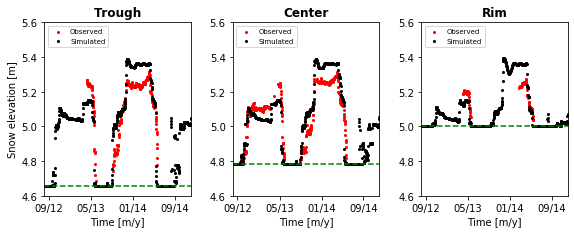

In [30]:
#plot_at_depths()
plot_SD_CT()

In [ ]:
def plot_SD_CT_Compare():
    fig, axs = plt.subplots(1,3, figsize=(6,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)

    plt.tight_layout()
    axs = axs.ravel()
    
    lambda1 , lambda2 = 1,1
    Elev_T, Elev_R, Elev_C = 4.65873, 5.00137, 4.78591
    ax = plt.subplot(131)
    #only account for the frozen water
    
    PD1_Frozen = [d1 if d2>1.2e-01 else 0 for d1,d2 in zip(DataSim1['ponded_depth-trough'],DataSim1['snow_depth-trough'])]
    Sim1_SD_Tr = [ lambda1*d1 + lambda2*Elev_T + d2 for d1,d2 in zip(PD1_Frozen,DataSim1['snow_depth-trough']) ]
    PD2_Frozen = [d1 if d2>1.2e-01 else 0 for d1,d2 in zip(DataSim2['ponded_depth-trough'],DataSim2['snow_depth-trough'])]
    Sim2_SD_Tr = [ lambda1*d1 + lambda2*Elev_T + d2 for d1,d2 in zip(PD2_Frozen,DataSim2['snow_depth-trough']) ]

    
    DataObservedSnowT = [lambda2*Elev_T + d for d in DataObservedSnow['snow_depth_Trough'] ]
    
    plt.plot(DataObservedSnow['snow_time_Trough_yr'], DataObservedSnowT,'r.',label='Observed')
    plt.plot(DataSim2['Time'], Sim1_SD_Tr,'k.',label='Simulated',)
    plt.plot(DataSim2['Time'], Sim2_SD_Tr,'g.',label='Simulated (no snow aging model)')
    
    ax.set_ylabel('Snow elevation [m]')
    ax.set_xlabel('Year')
    ax.set_title('Trough',fontweight='bold')
    ax.set_xlim((2012.7, 2014.5)) 
    ax.set_ylim((4.6, 5.6))
    plt.axhline(y=Elev_T,linestyle='--',color='g')
    plt.legend(loc='upper left',fontsize=6)
    
    ax = plt.subplot(132)
    
    PD1_Frozen = [d1 if d2>1.2e-01 else 0 for d1,d2 in zip(DataSim1['ponded_depth-center'],DataSim1['snow_depth-center'])]
    Sim1_SD_C = [ lambda1*d1 + lambda2*Elev_C + d2 for d1,d2 in zip(PD1_Frozen,DataSim1['snow_depth-center']) ]
    PD2_Frozen = [d1 if d2>1.2e-01 else 0 for d1,d2 in zip(DataSim2['ponded_depth-center'],DataSim2['snow_depth-center'])]
    Sim2_SD_C = [ lambda1*d1 + lambda2*Elev_C + d2 for d1,d2 in zip(PD2_Frozen,DataSim2['snow_depth-center']) ]


    DataObservedSnowC = [lambda2*Elev_C + d for d in DataObservedSnow['snow_depth_Center'] ]
    plt.plot(DataObservedSnow['snow_time_Center_yr'], DataObservedSnowC,'r.',label='Observed')
    plt.plot(DataSim2['Time'], Sim1_SD_C,'k.',label='Simulated')
    plt.plot(DataSim2['Time'], Sim2_SD_C,'g.',label='Simulated (no snow aging model)')
    
    ax.set_xlabel('Year')
    ax.set_title('Center',fontweight='bold')
    ax.set_xlim((2012.7, 2014.5)) 
    ax.set_ylim((4.6, 5.6))
    plt.axhline(y=Elev_C,linestyle='--',color='g')
    plt.legend(loc='upper left',fontsize=6)
    
    ax = plt.subplot(133)
    Sim1_SD_R = [ lambda1*d1 + lambda2*Elev_R for d1 in DataSim1['snow_depth-rim'] ]
    Sim2_SD_R = [ lambda1*d1 + lambda2*Elev_R for d1 in DataSim2['snow_depth-rim'] ]
    DataObservedSnowR = [lambda2*Elev_R + d for d in DataObservedSnow['snow_depth_Rim'] ]
    
    plt.plot(DataObservedSnow['snow_time_Rim_yr'], DataObservedSnowR,'r.',label='Observed')
    plt.plot(DataSim2['Time'], Sim1_SD_R,'k.',label='Simulated')
    plt.plot(DataSim2['Time'], Sim2_SD_R,'g.',label='Simulated (no snow aging model)')
    
    ax.set_xlabel('Year')
    ax.set_title('Rim',fontweight='bold')
    ax.set_xlim((2012.7, 2014.5)) 
    ax.set_ylim((4.6, 5.6))
    plt.axhline(y=Elev_R,linestyle='--',color='g')
    plt.legend(loc='upper left',fontsize=7)
    
    #plt.savefig(outfile+'%s-SD.pdf'%(simulation[0] + simulation[1]), bbox_inches='tight', dpi=600)

In [ ]:
plot_SD_CT_Compare()

In [ ]:
# PLOTTING FORCING DATA USED FOR MODEL EVALUATION

In [ ]:
import h5py
AnnaData = h5py.File('/Users/ajc/Desktop/SimDataInputs/forcing_data/Barrow/Barrow-Validation/Barrow-2010_2016-updated-30pc.h5')

fig, axs = plt.subplots(1,2, figsize=(6,3), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)

plt.tight_layout()
axs = axs.ravel()

Time = [2010 + t/(86400*365) for t in AnnaData['time [s]']]
Snow = [s*1000*86400 for s in AnnaData['precipitation snow [m SWE s^-1]']]
Rain = [s*1000*86400 for s in AnnaData['precipitation rain [m s^-1]']]
ax1 = plt.subplot(121)

plt.plot(Time,AnnaData['air temperature [K]'],'r',linewidth=1)
ax1.set_ylabel('Air temperature [K]')
ax1.set_xlabel('Year')
plt.axhline(y=273.15,linestyle='--',color='g',linewidth=1)
ax1.set_xlim(2012,2015)
ax1.set_ylim(230,290)

ax2 = plt.subplot(122)
ax2.plot(Time,Snow,color='gray',label='Snow',linewidth=1)
ax2.plot(Time,Rain,'b',label='Rain',linewidth=1)
ax2.set_ylabel('Precipitation [mm]')
ax2.set_xlabel('Year')
ax2.set_xlim(2012,2015)
ax2.set_ylim(-0.,30)
plt.legend(loc='upper left',fontsize=8)

#plt.savefig(outfile+'forcing_Tair_precip.pdf', bbox_inches='tight', dpi=600)

In [ ]:
%matplotlib 
DataSim2['surface_evaporation_T'] = DataSim2['surface-evaporation-trough']
DataSim2['surface_evaporation_C'] = DataSim2['surface-evaporation-center']
DataSim2['surface_evaporation_R'] = DataSim2['surface-evaporation-rim']
#Evaporative flux
def local_axes():
    plt.xlabel('Year')
    #ax.set_xlim((2012.7, 2014.5))
    plt.ylim((-2, 8.0))
    #plt.legend(loc='upper left',fontsize=6)

molar_den =1000./0.0180153
print (1000* 86.4*0.07/molar_den)
def plot_EvaporativeFlux(location = 'trough'):
    fig, axs = plt.subplots(1,3, figsize=(8,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1,1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)

    plt.tight_layout()
    axs = axs.ravel()
    
    lambda1 , lambda2 = 1,1
    Elev_T, Elev_R, Elev_C = 4.65873, 5.00137, 4.78591
    ax = plt.subplot(131)
    days_et = 315 + 205
    
    Observed_E_C, Observed_E_T,Observed_E_R = 0.11, 0.11, 0.11
    Volume = [2.54729, 0.104032, 2.06396] # Trough, center, rim
    snow_depth_Tr = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_T'] ]
    simulated_E_Tr = np.mean(snow_depth_Tr[days_et:days_et+30])/Volume[0] #<<<--------------------
    ET_literature = 0.5*(0.8 + 4.2)
    Error = ET_literature/1. -0.8
    plt.plot(DataSim2['Time'], snow_depth_Tr,'k.',label='Simulated')
    plt.plot(DataSim2['Time'][days_et],Observed_E_C,'r*',label='Observed')
    plt.plot(DataSim2['Time'][days_et],simulated_E_Tr,'g*',label='Simulated')
    plt.errorbar(DataSim2['Time'][days_et], ET_literature, yerr=Error, fmt='b*')
    
    ax.set_ylabel('Evaporative flux [mm]')
    
    ax.set_title('Trough',fontweight='bold')
    local_axes()
    
    ax = plt.subplot(132)
       
    
    snow_depth_C = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_C'] ]
    simulated_E_C = np.mean(snow_depth_C[days_et:days_et+3])/Volume[1] #<<<--------------------
    plt.plot(DataSim2['Time'], snow_depth_C,'k.',label='Simulated')
    plt.plot(DataSim2['Time'][days_et],Observed_E_C,'r*',label='Observed')
    plt.plot(DataSim2['Time'][days_et],simulated_E_Tr,'g*',label='Simulated')
    plt.errorbar(DataSim2['Time'][days_et], ET_literature, yerr=Error, fmt='b*')
    ax.set_title('Center',fontweight='bold')
    
    plt.legend(loc='upper left',fontsize=6)
    local_axes()
    ax = plt.subplot(133)

    snow_depth_R = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_R'] ]
    simulated_E_R = np.mean(snow_depth_R[days_et:days_et+3])/Volume[2] #<<<--------------------
    plt.plot(DataSim2['Time'], snow_depth_R,'k.',label='Simulated')
    plt.plot(DataSim2['Time'][days_et],Observed_E_C,'r*',label='Observed')
    plt.plot(DataSim2['Time'][days_et],simulated_E_Tr,'g*',label='Simulated')
    plt.errorbar(DataSim2['Time'][days_et], ET_literature, yerr=Error, fmt='b*')
    ax.set_title('Rim',fontweight='bold')
    local_axes()
    
    plt.legend(loc='upper left',fontsize=6)
    
    
    #plt.legend(loc='upper right', fontsize=10, ncol=3, bbox_to_anchor=(0.9,-0.3, .1, .1))
    #plt.tight_layout()
    #plt.savefig(outfile+'%s-SD-%s.pdf'%(simulation[0] + simulation[0], location), bbox_inches='tight', dpi=600)

In [ ]:
plot_EvaporativeFlux()